<a href="https://colab.research.google.com/github/boorashiva12/AIML-Training-Shiva/blob/main/Assignment_Day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Day-1 Assignment**


1. Hand made kernels

  * Experiment with different kernels – average filter? Sharpening? Diagonal Edge detector?


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

In [4]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [5]:
# Image loading

image = cv2.imread('/bird.jpeg', 0)

In [6]:
# Averaging Filter

filter1 = 1/9* np.ones([3,3])

out1 = apply_conv(image, filter1, padding=0, stride=1)

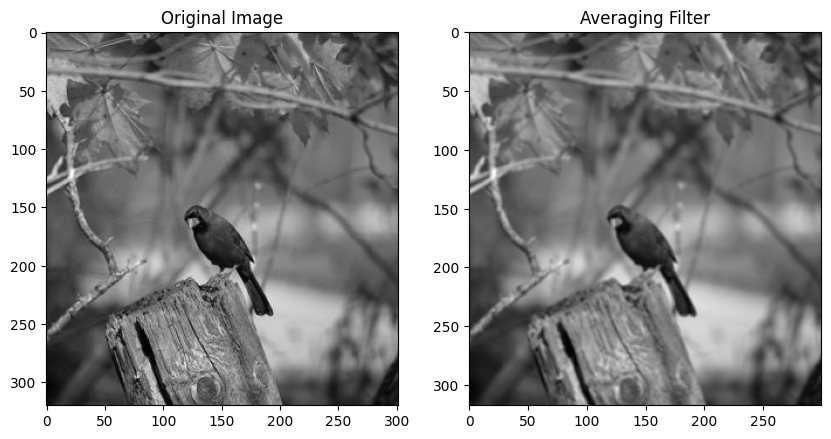

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,2,2)
ax.set_title('Averaging Filter')
ax.imshow(out1, cmap='gray')

plt.show()


In [8]:
# Sharpening Filter

filter2 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])

out2 = apply_conv(image, filter2, padding=0, stride=1)


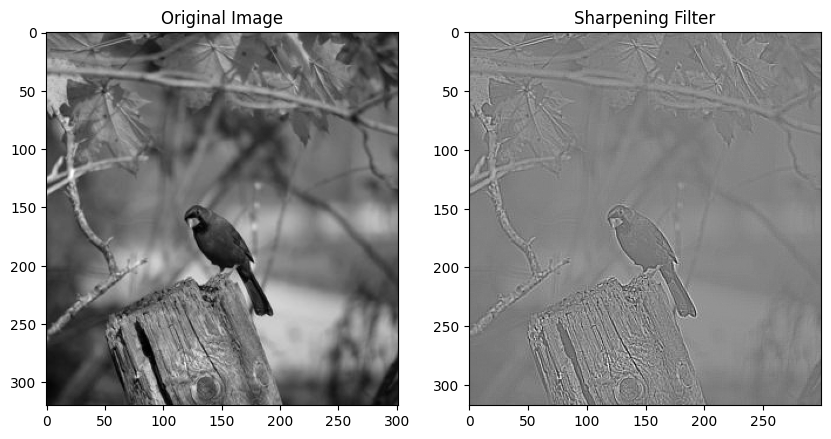

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,2,2)
ax.set_title('Sharpening Filter')
ax.imshow(out2, cmap='gray')

plt.show()

In [10]:
# Horizonal Edge Filter

filter3_1 = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out3_1 = apply_conv(image, filter3_1, padding=0, stride=1)


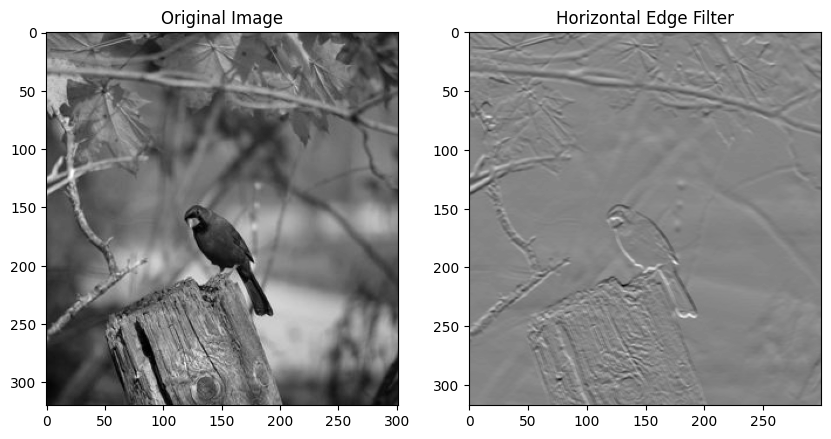

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,2,2)
ax.set_title('Horizontal Edge Filter')
ax.imshow(out3_1, cmap='gray')

plt.show()

In [12]:
# Vertical  Edge Filter

filter3_2 = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out3_2 = apply_conv(image, filter3_2, padding=0, stride=1)

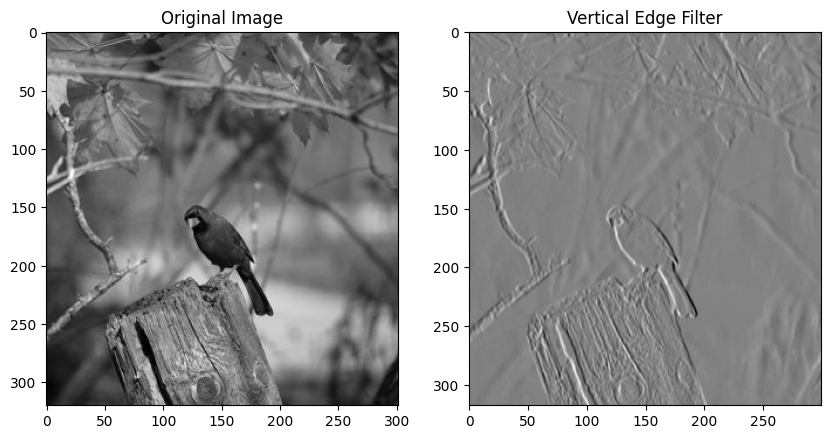

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,2,2)
ax.set_title('Vertical Edge Filter')
ax.imshow(out3_2, cmap='gray')

plt.show()

**Day-1 Assignment**


2. Our own CNN.

*   Experiment with different number of layers, different orders of layers, different kernel sizes, different number of epochs










In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13257464.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [5]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [6]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [9]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [10]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0129, Accuracy: 39.4520
Epoch 2/5, Loss: 0.0095, Accuracy: 56.6820
Epoch 3/5, Loss: 0.0080, Accuracy: 64.2660
Epoch 4/5, Loss: 0.0068, Accuracy: 69.3360
Epoch 5/5, Loss: 0.0059, Accuracy: 73.4580


In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [ ]:
# Accuracy on test data after training
test_model(model, testloader)